# Correlation analysis
Here we perform different correlation analyses between genes from our transcriptomics dataset and protein yield
- 1 - Correlation between genes and protein yield in the entire dataset
- 2 - Correlation between genes and protein yield within Cluster 3
- 3 - Correlation between genes and protein yield between Low and High producers

In [37]:
# Import required libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [2]:
# Define file paths
abundance_file = 'data/rnaseq_abundance.csv'
counts_file = 'data/rnaseq_counts.csv'
length_file = 'data/rnaseq_length.csv'

# Load data
abundance_data = pd.read_csv(abundance_file, index_col=0)
counts_data = pd.read_csv(counts_file, index_col=0)
length_data = pd.read_csv(length_file, index_col=0)

## Normalize the counts to TPMs
1 - Calculate RPK (Reads Per Kilobase): Divide the counts by the gene length (in kilobases).

3 - Calculate the Scaling Factor: Sum up the RPK values for each sample to get a total RPK value.

4 - Normalize to TPM: Divide each gene's RPK by the total RPK for the respective sample, then multiply by 

In [3]:
# Define a function to normalize counts to TPMs
def normalize_to_tpm(counts_df, lengths_df):
    # Step 1: Calculate RPK
    lengths_kb = lengths_df / 1000  # Convert lengths to kilobases
    rpk = counts_df.div(lengths_kb)

    # Step 2: Calculate scaling factors (sum of RPKs for each sample)
    scaling_factors = rpk.sum(axis=0)

    # Step 3: Normalize to TPM
    tpm = rpk.div(scaling_factors) * 1e6

    return tpm

# Perform normalization
tpm_data = normalize_to_tpm(counts_data, length_data)

## Load protein data and combine with rna_seq

In [4]:
# Load protein yield data
protein_yield_data = pd.read_csv('data/supplementary_data_1.csv')
# Load protein specific data
protein_specific_data = pd.read_excel('data/media-4.xlsx', sheet_name='all features')

# Ensure 'Total.purified.protein_stock1.stock2_microg' is float and fill NaN with 0
protein_yield_data['Total.purified.protein_stock1.stock2_microg'] = pd.to_numeric(
    protein_yield_data['Total.purified.protein_stock1.stock2_microg'], errors='coerce'
).fillna(0)

# Select relevant columns from the protein yield data
protein_yield = protein_yield_data[['sample_ID', 'genes', 'Total.purified.protein_stock1.stock2_microg', 'amount_microgram']]
# Select relevant columns from the protein specific data
aa_comp_c = protein_specific_data[['human_symbol', 'sequence_AA.comp_AA.Comp_C']]

# Merge both dfs
merged_df = protein_yield.merge(
    aa_comp_c,  # select only the relevant columns from aa_comp_C
    left_on='genes',       # the key column in protein_yield
    right_on='human_symbol',  # the key column in aa_comp_C
    how='left'             # left join ensures all protein_yield rows are kept
)


# Ensure sample_ID matches TPM column names
merged_df.set_index('sample_ID', inplace=True)

# Align TPM data with protein yield data
aligned_tpm_data = tpm_data.loc[:, merged_df.index]

# Combine the TPM data with protein yield data
combined_data = aligned_tpm_data.T.reset_index()  # Transpose to align samples and reset index
combined_data.set_index('sample_ID', inplace=True)
combined_data['Total_protein_microg'] = merged_df['Total.purified.protein_stock1.stock2_microg'].values
combined_data['Category'] = merged_df['amount_microgram'].values
combined_data['Comp_C'] = merged_df['sequence_AA.comp_AA.Comp_C'].values

In [5]:
# Define set of experimentally validated genes

# List of custom genes
custom_genes = ['Agpat4', 'LOC100750792', 'Nsd1', # Mina's
                'LOC100757909', 'Hspa8', 'Ern1', #Malm's
                'Pdia3', 'Uggt1', 'Rpn1'] # Giulia's

# Check which custom genes are present in the combined data columns
present_genes = [gene for gene in custom_genes if gene in combined_data.columns]
missing_genes = [gene for gene in custom_genes if gene not in combined_data.columns]

# Display results
print(f"Present genes: {present_genes}")
print(f"Missing genes: {missing_genes}")

Present genes: ['Agpat4', 'LOC100750792', 'Nsd1', 'LOC100757909', 'Hspa8', 'Ern1', 'Pdia3', 'Uggt1', 'Rpn1']
Missing genes: []


## 1 - Correlation between genes and protein yield in the entire dataset

In [6]:
# Filter out genes with constant values or missing data
filtered_data = combined_data.dropna(axis=1).loc[:, combined_data.nunique() > 1]

# Initialize a dictionary to store correlation results
correlation_results = {'Gene': [], 'Correlation': [], 'P-Value': []}

# Iterate over each gene
for gene in filtered_data.columns[:-1]:  # Exclude 'Total_protein_microg'
    gene_expression = filtered_data[gene]
    protein_production = filtered_data['Total_protein_microg']

    # Calculate Pearson correlation
    corr, p_value = pearsonr(gene_expression, protein_production)

    # Append results
    correlation_results['Gene'].append(gene)
    correlation_results['Correlation'].append(corr)
    correlation_results['P-Value'].append(p_value)

# Convert results to a DataFrame
correlation_df = pd.DataFrame(correlation_results).sort_values(by='Correlation', ascending=False)
correlation_df.reset_index(inplace=True, drop=True)

# Display results
print("Top Genes Positively Correlated with Protein Production:")
print(correlation_df.head(10))
print('')
print("Top Genes Negatively Correlated with Protein Production:")
print(correlation_df.tail(10))

Top Genes Positively Correlated with Protein Production:
           Gene  Correlation       P-Value
0  LOC100755269     0.598517  1.192523e-10
1         Stx19     0.598517  1.192523e-10
2        Gimap6     0.598517  1.192523e-10
3        Mgat5b     0.488340  4.479329e-07
4         Cldn2     0.407018  3.865814e-05
5  LOC100751635     0.404135  4.437505e-05
6          Zbbx     0.388255  9.276676e-05
7          Cdh2     0.369094  2.151300e-04
8  LOC100767578     0.368608  2.196256e-04
9          Ryr2     0.358432  3.360318e-04

Top Genes Negatively Correlated with Protein Production:
               Gene  Correlation   P-Value
20063          Fn3k    -0.256537  0.011636
20064  LOC103161115    -0.257307  0.011379
20065  LOC103164406    -0.260528  0.010358
20066  LOC103159353    -0.262427  0.009794
20067       Ankrd23    -0.263505  0.009486
20068  LOC103162644    -0.287149  0.004559
20069  LOC107980021    -0.295095  0.003514
20070         Setd9    -0.304265  0.002579
20071  LOC100773247    -0

### 1.1 Barplot top 10 negatively and positively correlated genes

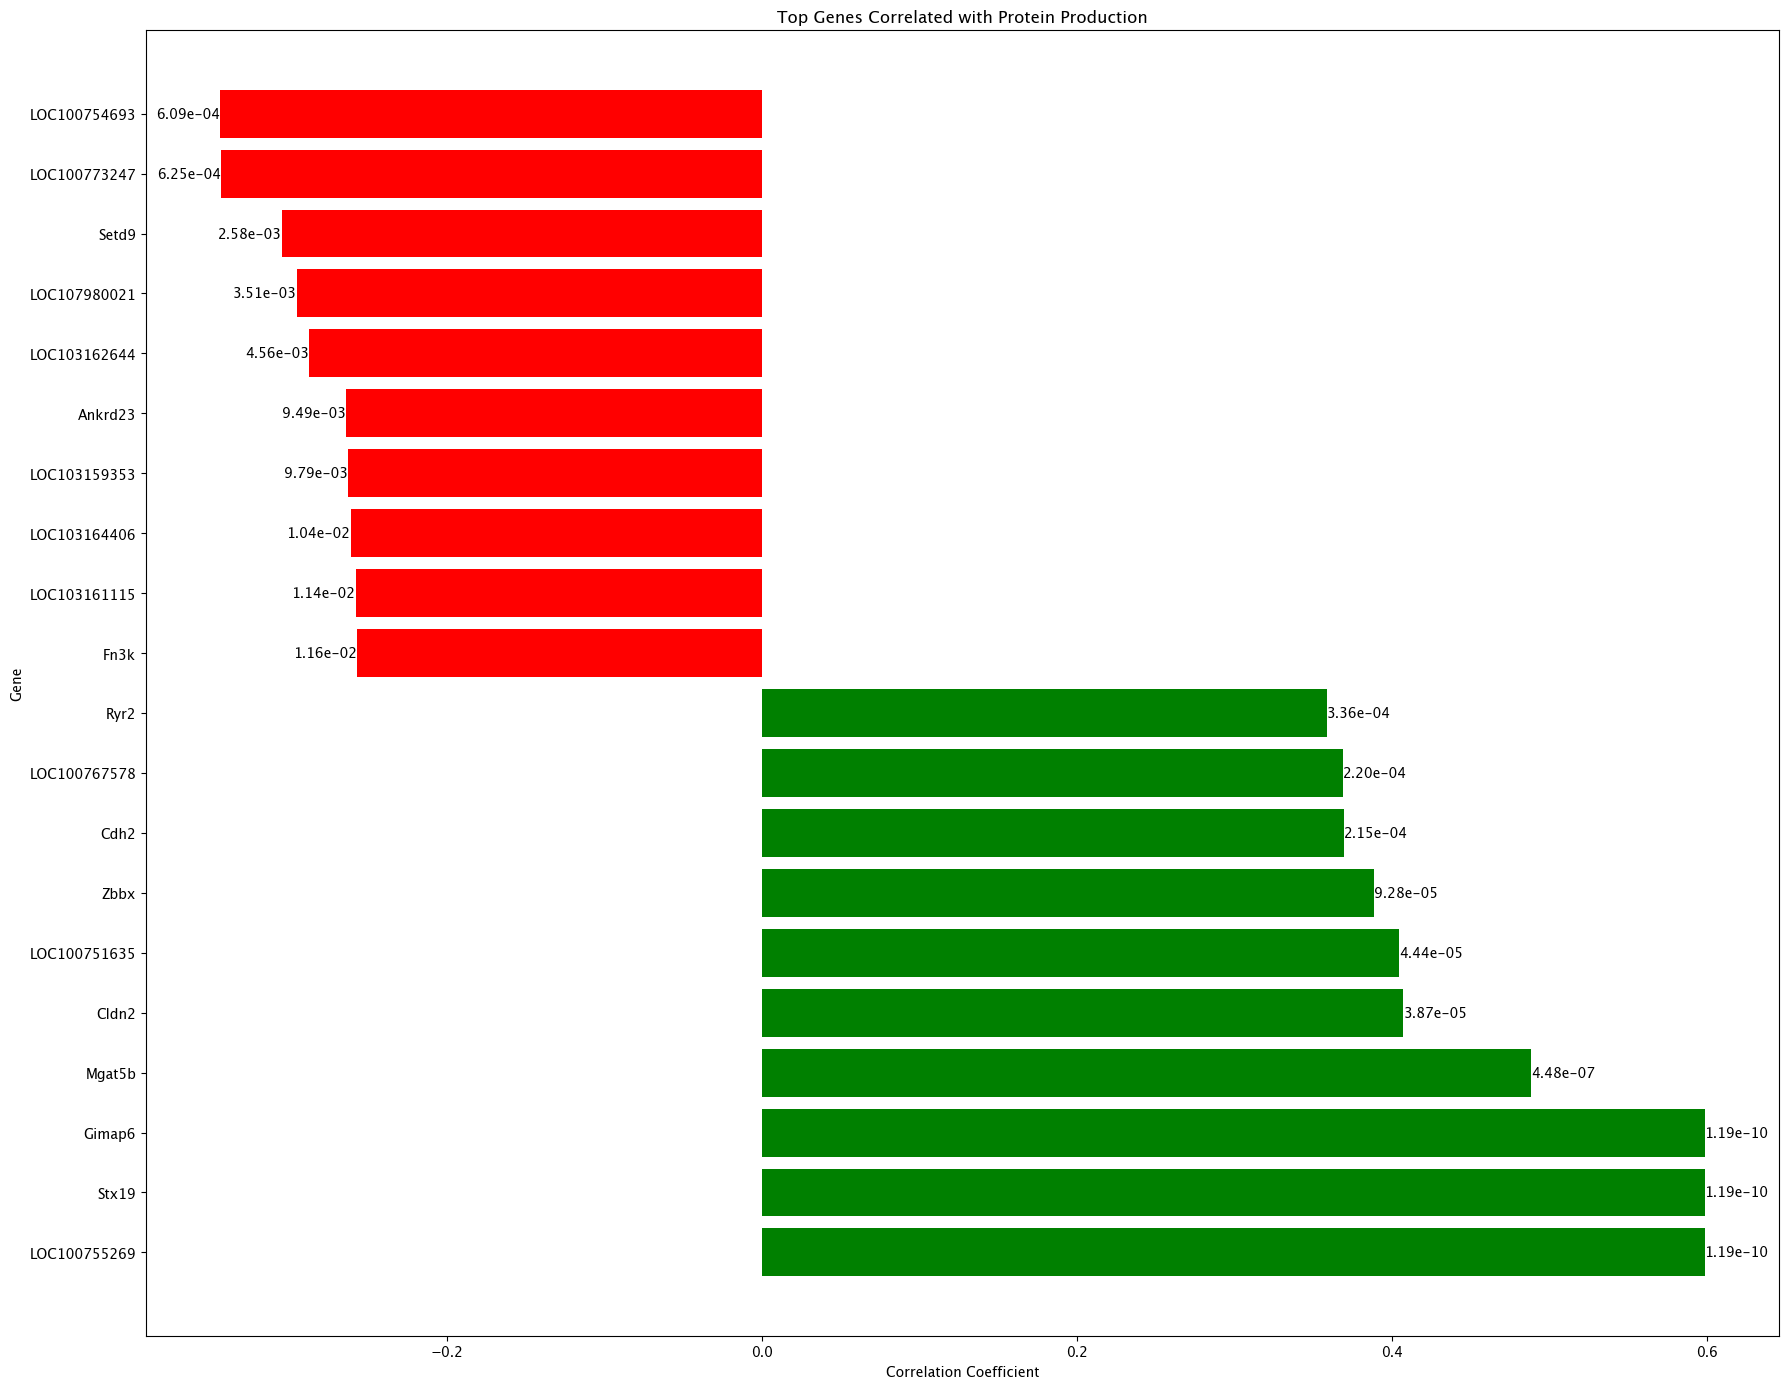

In [7]:
# Select top 10 positively and negatively correlated genes
selected_genes = pd.concat([correlation_df.head(10), correlation_df.tail(10)], ignore_index=True)

# Visualize correlations using a bar plot with p-values
plt.figure(figsize=(18, 14))
bars = plt.barh(
    selected_genes['Gene'], 
    selected_genes['Correlation'], 
    color=['green' if corr > 0 else 'red' for corr in selected_genes['Correlation']]
)

# Annotate bars with p-values
for bar, p_value in zip(bars, selected_genes['P-Value']):
    plt.text(
        bar.get_width(),  # Position at the end of the bar
        bar.get_y() + bar.get_height() / 2,  # Center vertically on the bar
        f'{p_value:.2e}',  # Format p-value in scientific notation
        va='center',  # Align vertically centered
        ha='left' if bar.get_width() > 0 else 'right'  # Adjust alignment for positive/negative bars
    )

plt.title('Top Genes Correlated with Protein Production')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Gene')
plt.tight_layout()
plt.show()


### 1.2 Barplot experimentally tested genes

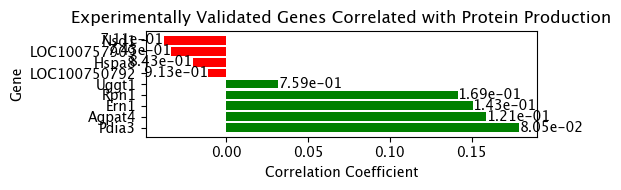

In [8]:
# Filter correlation_df for the custom genes only
selected_genes = correlation_df[correlation_df['Gene'].isin(custom_genes)].reset_index(drop=True)

plt.figure(figsize=(6, 2))
bars = plt.barh(
    selected_genes['Gene'], 
    selected_genes['Correlation'], 
    color=['green' if corr > 0 else 'red' for corr in selected_genes['Correlation']]
)

# Annotate bars with p-values
for bar, p_value in zip(bars, selected_genes['P-Value']):
    plt.text(
        bar.get_width(),  # Position at the end of the bar
        bar.get_y() + bar.get_height() / 2,  # Center vertically on the bar
        f'{p_value:.2e}',  # Format p-value in scientific notation
        va='center',  # Align vertically centered
        ha='left' if bar.get_width() > 0 else 'right'  # Adjust alignment for positive/negative bars
    )

plt.title('Experimentally Validated Genes Correlated with Protein Production')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Gene')
plt.tight_layout()
plt.show()

## 2 - Correlation between genes and protein yield within Cluster 3

In [9]:
# Load cluster assingment dataset
sec_clusters = pd.read_excel('data/Secretome_clusterAssignment.xlsx')
# Create dictionary for mapping
sample_cluster_dict = dict(zip(sec_clusters['sample_ID'], sec_clusters['cluster']))

In [10]:
# Filter dataset to subset only cluster 3

# Map the cluster values to the sample_ID column
filtered_data['Cluster'] = filtered_data.index.map(sample_cluster_dict).fillna(-1).astype(int)

# Filter for samples in cluster 3
cluster_3_data = filtered_data[filtered_data['Cluster'] == 3].drop(columns=['Cluster'])

In [11]:
# Initialize a dictionary to store correlation results
correlation_results = {'Gene': [], 'Correlation': [], 'P-Value': []}

# Iterate over each gene
for gene in cluster_3_data.columns[:-1]:  # Exclude 'Total_protein_microg'
    gene_expression = cluster_3_data[gene]
    protein_production = cluster_3_data['Total_protein_microg']

    # Calculate Pearson correlation
    corr, p_value = pearsonr(gene_expression, protein_production)

    # Append results
    correlation_results['Gene'].append(gene)
    correlation_results['Correlation'].append(corr)
    correlation_results['P-Value'].append(p_value)

# Convert results to a DataFrame
correlation_df = pd.DataFrame(correlation_results).sort_values(by='Correlation', ascending=False)
correlation_df.reset_index(inplace=True, drop=True)

/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/ipykernel_13799/480338098.py:10: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_value = pearsonr(gene_expression, protein_production)


### 2.1 Barplot top 10 negatively and positively correlated genes

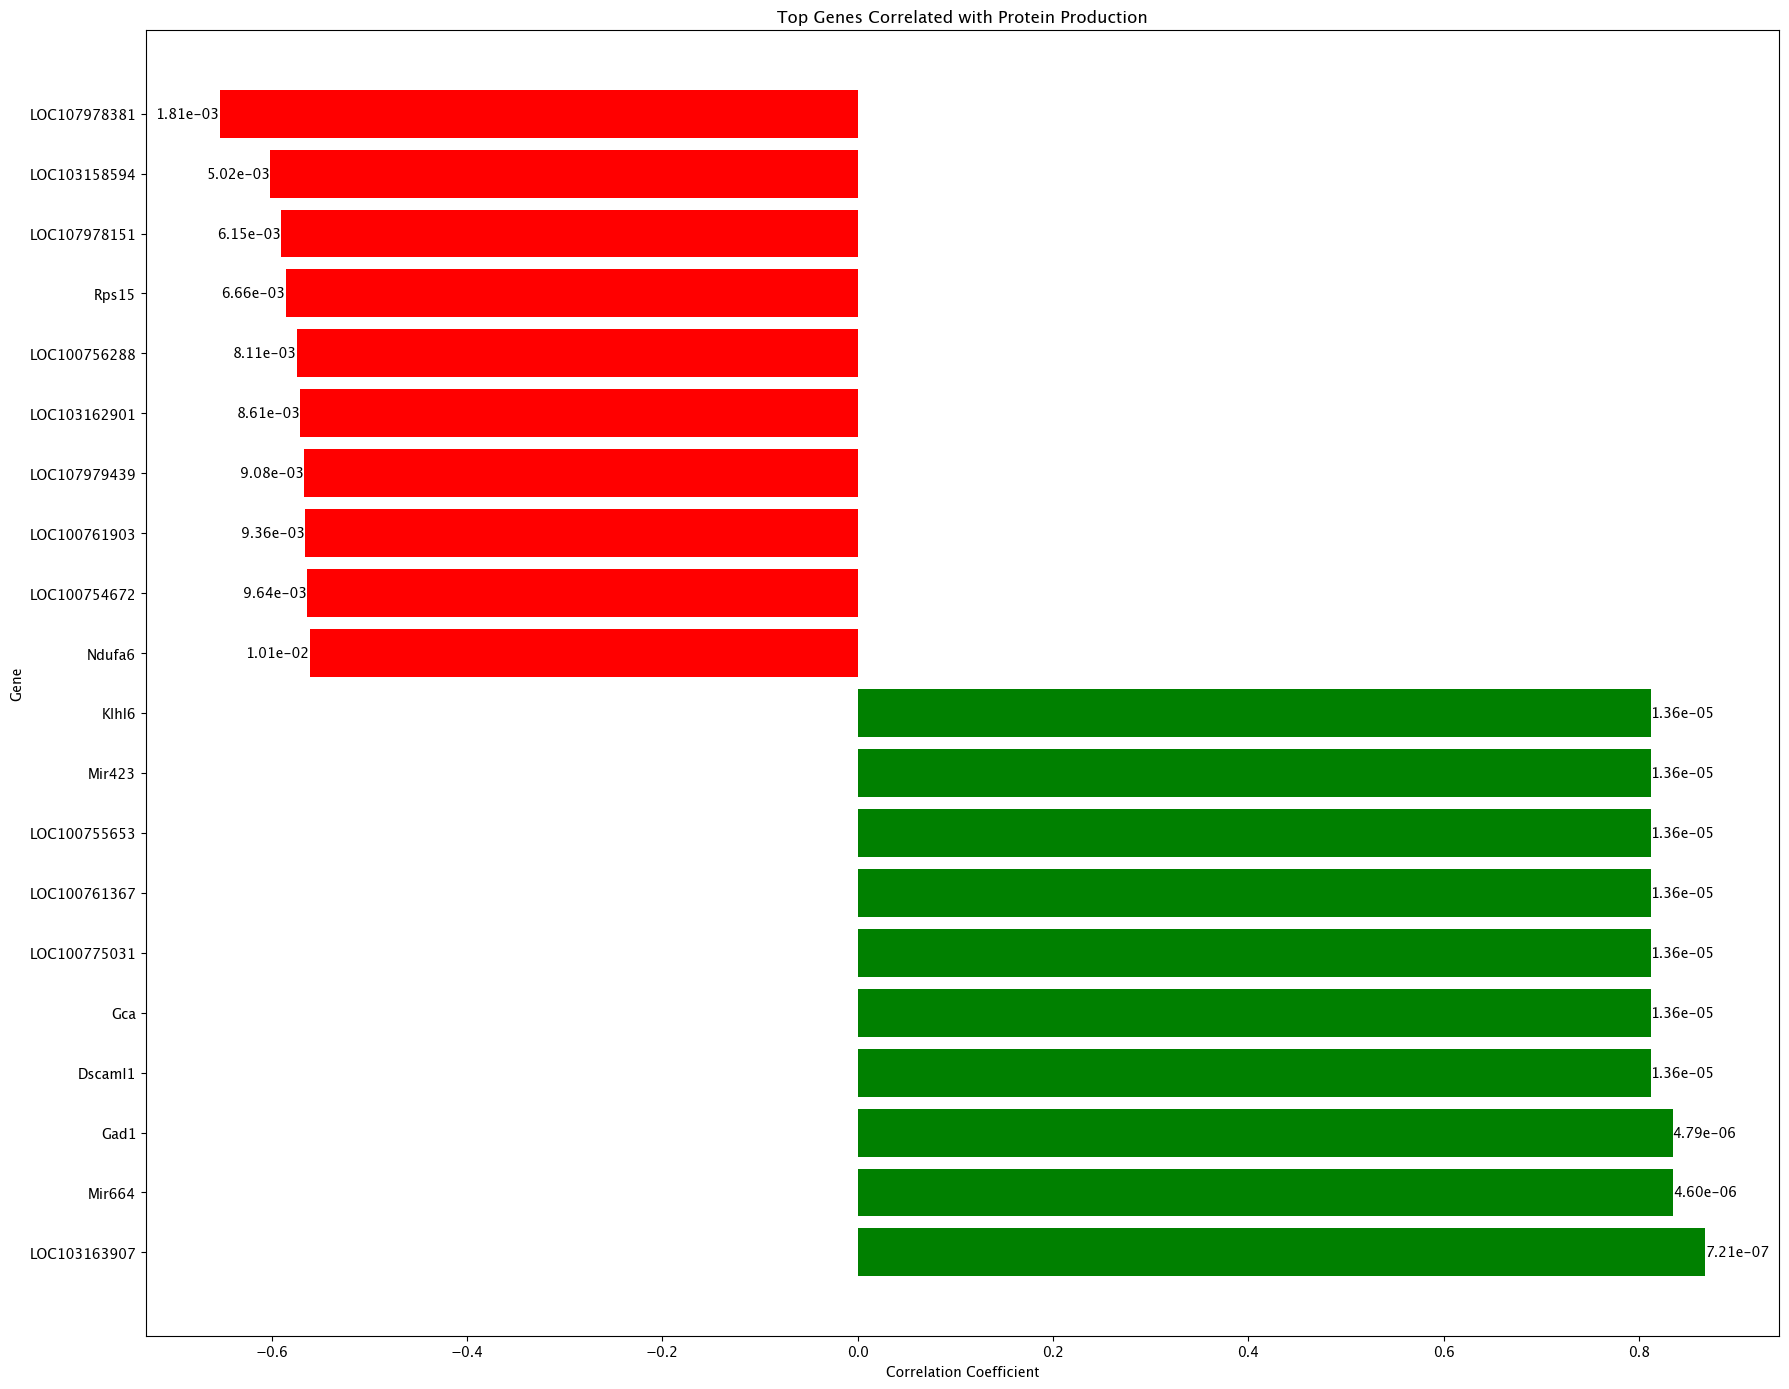

In [12]:
filtered_correlation_df = correlation_df[
    correlation_df['Correlation'].notnull() & correlation_df['P-Value'].notnull()
]

# Select top 10 positively and negatively correlated genes
selected_genes = pd.concat([filtered_correlation_df.head(10), filtered_correlation_df.tail(10)], ignore_index=True)

# Visualize correlations using a bar plot with p-values
plt.figure(figsize=(18, 14))
bars = plt.barh(
    selected_genes['Gene'], 
    selected_genes['Correlation'], 
    color=['green' if corr > 0 else 'red' for corr in selected_genes['Correlation']]
)

# Annotate bars with p-values
for bar, p_value in zip(bars, selected_genes['P-Value']):
    plt.text(
        bar.get_width(),  # Position at the end of the bar
        bar.get_y() + bar.get_height() / 2,  # Center vertically on the bar
        f'{p_value:.2e}',  # Format p-value in scientific notation
        va='center',  # Align vertically centered
        ha='left' if bar.get_width() > 0 else 'right'  # Adjust alignment for positive/negative bars
    )

plt.title('Top Genes Correlated with Protein Production')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Gene')
plt.tight_layout()
plt.show()

### 2.2 Barplot experimentally tested genes

posx and posy should be finite values
posx and posy should be finite values


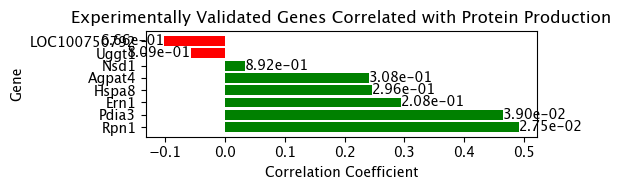

In [13]:
# Filter correlation_df for the custom genes only
selected_genes = correlation_df[correlation_df['Gene'].isin(custom_genes)].reset_index(drop=True)

plt.figure(figsize=(6, 2))
bars = plt.barh(
    selected_genes['Gene'], 
    selected_genes['Correlation'], 
    color=['green' if corr > 0 else 'red' for corr in selected_genes['Correlation']]
)

# Annotate bars with p-values
for bar, p_value in zip(bars, selected_genes['P-Value']):
    plt.text(
        bar.get_width(),  # Position at the end of the bar
        bar.get_y() + bar.get_height() / 2,  # Center vertically on the bar
        f'{p_value:.2e}',  # Format p-value in scientific notation
        va='center',  # Align vertically centered
        ha='left' if bar.get_width() > 0 else 'right'  # Adjust alignment for positive/negative bars
    )

plt.title('Experimentally Validated Genes Correlated with Protein Production')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Gene')
plt.tight_layout()
plt.show()

## 3 - Correlation between genes and protein yield between Low and High producers

In [54]:
# Filter combined_data based on the 'Category' column
highlow_combined_data = combined_data[
    combined_data['Category'].isin(['highest amount', 'no amount'])
]

# Drop the 'Category' column
highlow_combined_data = highlow_combined_data.drop(columns=['Category'])

In [55]:
# Filter out genes with constant values or missing data
filtered_data = highlow_combined_data.dropna(axis=1).loc[:, highlow_combined_data.nunique() > 1]

# Initialize a dictionary to store correlation results
correlation_results = {'Gene': [], 'Correlation': [], 'P-Value': []}

# Iterate over each gene
for gene in filtered_data.columns[:-1]:  # Exclude 'Total_protein_microg'
    gene_expression = filtered_data[gene]
    protein_production = filtered_data['Total_protein_microg']

    # Calculate Pearson correlation
    corr, p_value = pearsonr(gene_expression, protein_production)

    # Append results
    correlation_results['Gene'].append(gene)
    correlation_results['Correlation'].append(corr)
    correlation_results['P-Value'].append(p_value)

# Convert results to a DataFrame
correlation_df = pd.DataFrame(correlation_results).sort_values(by='Correlation', ascending=False)
correlation_df.reset_index(inplace=True, drop=True)

# Display results
print("Top Genes Positively Correlated with Protein Production:")
print(correlation_df.head(10))
print('')
print("Top Genes Negatively Correlated with Protein Production:")
print(correlation_df.tail(10))

Top Genes Positively Correlated with Protein Production:
           Gene  Correlation   P-Value
0  LOC107978826     0.806997  0.000030
1          Ano6     0.768687  0.000120
2  LOC100772093     0.764894  0.000136
3          Il20     0.758828  0.000165
4        Hivep1     0.757982  0.000170
5  LOC100761556     0.757557  0.000172
6  LOC107980087     0.756270  0.000179
7          Fggy     0.753414  0.000196
8         Peak1     0.747937  0.000231
9         Prkcd     0.743952  0.000260

Top Genes Negatively Correlated with Protein Production:
               Gene  Correlation   P-Value
18504        Smim20    -0.701954  0.000808
18505         Rps26    -0.702755  0.000792
18506         Crocc    -0.705790  0.000734
18507  LOC103164274    -0.706443  0.000722
18508  LOC107980326    -0.711871  0.000629
18509         Nr2f6    -0.715685  0.000570
18510  LOC103158789    -0.719290  0.000518
18511        Gtpbp6    -0.723480  0.000464
18512         Cxxc5    -0.725170  0.000443
18513  LOC100756957    -0.

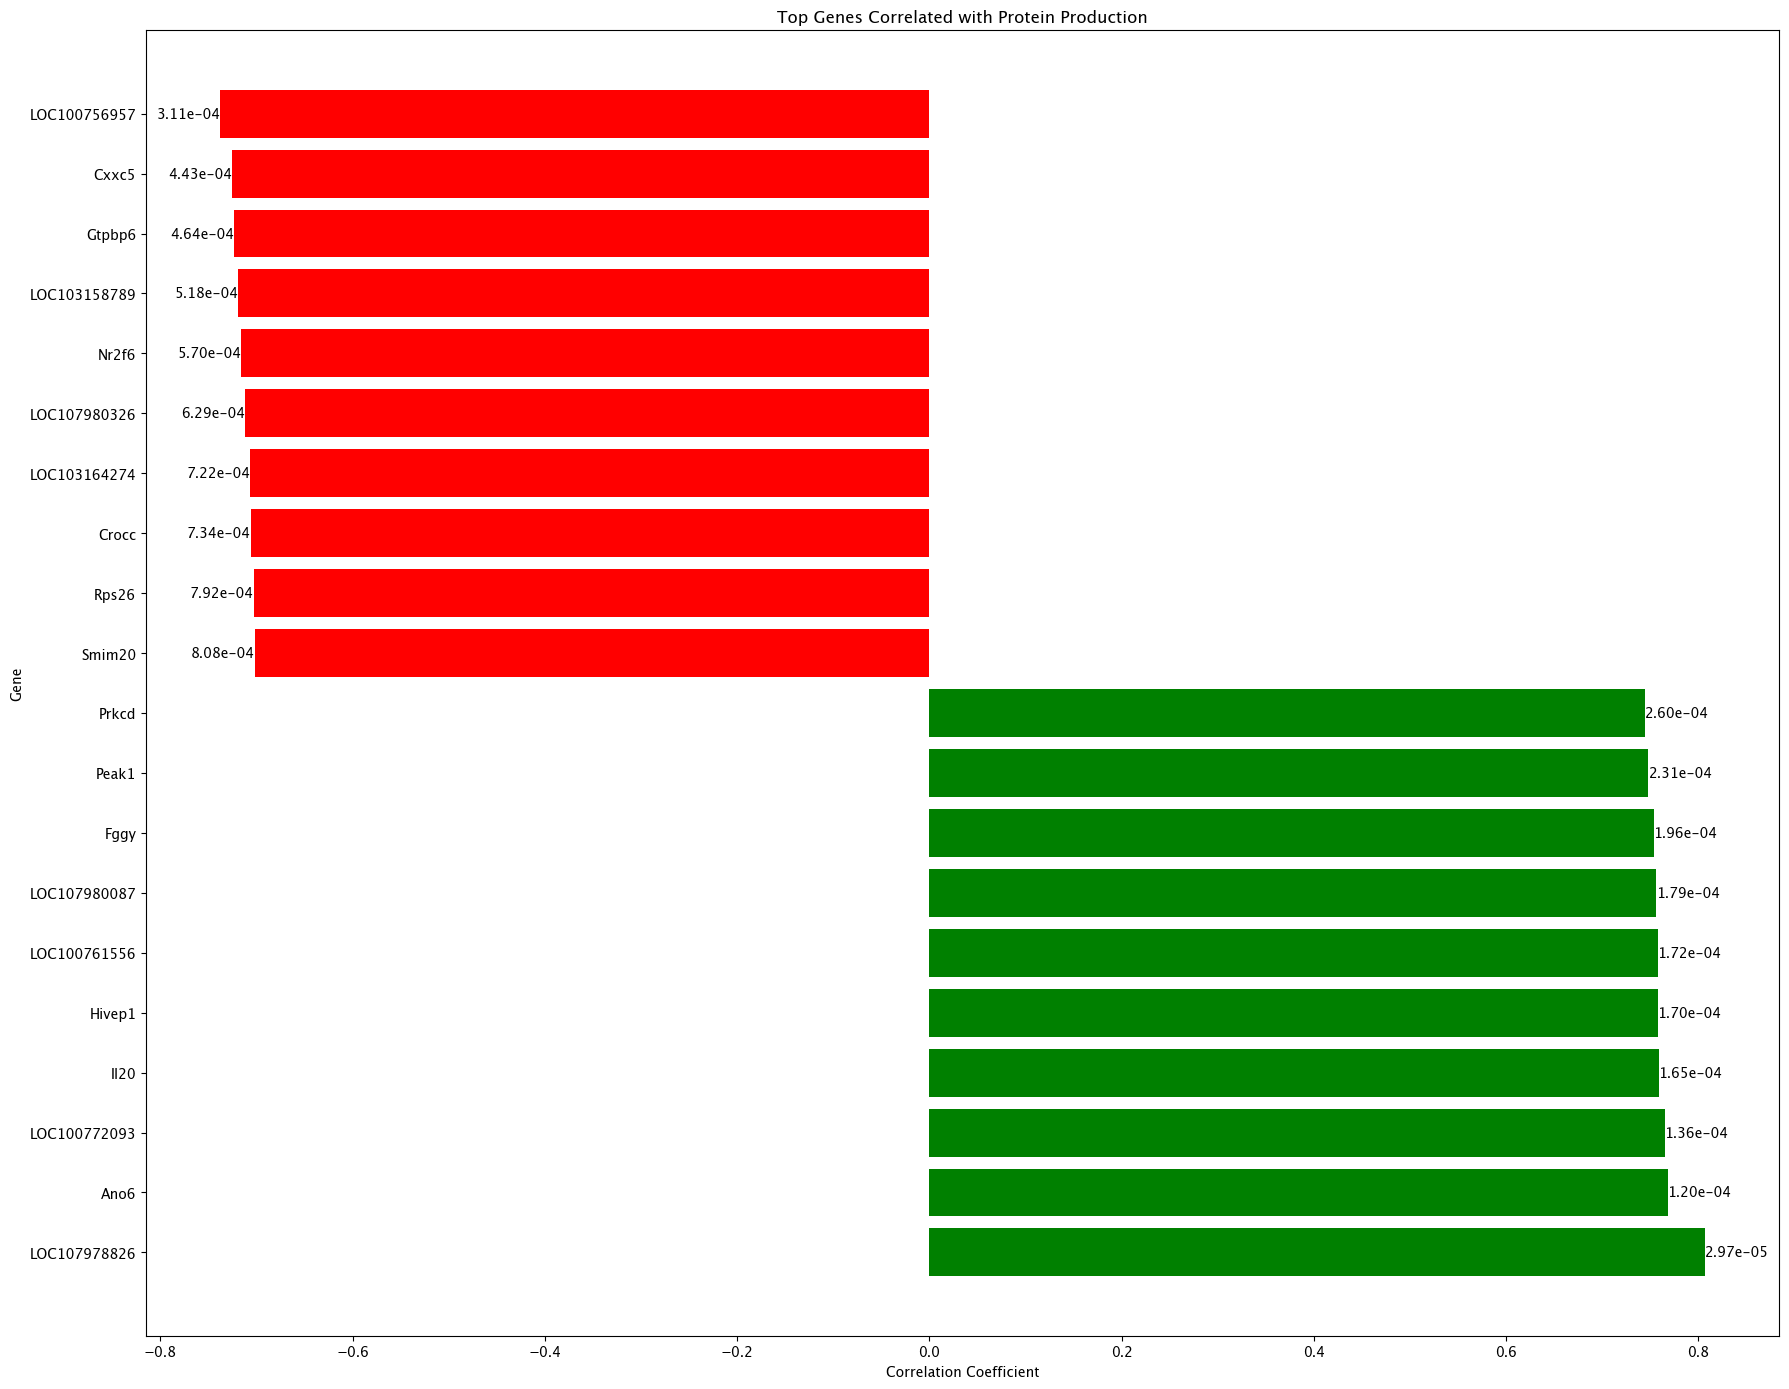

In [56]:
filtered_correlation_df = correlation_df[
    correlation_df['Correlation'].notnull() & correlation_df['P-Value'].notnull()
]

# Select top 10 positively and negatively correlated genes
selected_genes = pd.concat([filtered_correlation_df.head(10), filtered_correlation_df.tail(10)], ignore_index=True)

# Visualize correlations using a bar plot with p-values
plt.figure(figsize=(18, 14))
bars = plt.barh(
    selected_genes['Gene'], 
    selected_genes['Correlation'], 
    color=['green' if corr > 0 else 'red' for corr in selected_genes['Correlation']]
)

# Annotate bars with p-values
for bar, p_value in zip(bars, selected_genes['P-Value']):
    plt.text(
        bar.get_width(),  # Position at the end of the bar
        bar.get_y() + bar.get_height() / 2,  # Center vertically on the bar
        f'{p_value:.2e}',  # Format p-value in scientific notation
        va='center',  # Align vertically centered
        ha='left' if bar.get_width() > 0 else 'right'  # Adjust alignment for positive/negative bars
    )

plt.title('Top Genes Correlated with Protein Production')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Gene')
plt.tight_layout()
plt.show()

In [57]:
# -------------------------------------------
# 1) RENAME “LOC” GENES TO STANDARD SYMBOLS
# -------------------------------------------
rename_dict = {
    'LOC100757909': 'Eif2ak2',  # Malm’s
    'LOC100750792': 'Ephx1'     # Mina’s
}

# -------------------------------------------
# 2) CREATE A PAPER/GROUP MAPPING & COLOR MAP
# -------------------------------------------
paper_mapping = {
    'Mina':    ['Agpat4', 'Ephx1',  'Nsd1'],
    'Malm':    ['Eif2ak2', 'Hspa8', 'Ern1'],
    'Giulia':  ['Pdia3',   'Uggt1', 'Rpn1']
}

paper_color_dict = {
    'Mina':   'royalblue',
    'Malm':   'darkorange',
    'Giulia': 'forestgreen'
}

def get_paper(gene):
    """Return the paper/group name given a gene."""
    for paper, gene_list in paper_mapping.items():
        if gene in gene_list:
            return paper
    return 'Unknown'

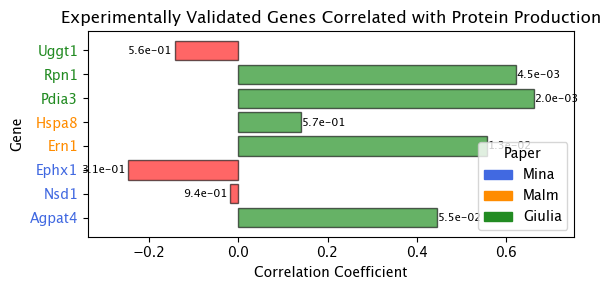

In [60]:
# Filter correlation_df for the custom genes only
selected_genes = correlation_df[correlation_df['Gene'].isin(custom_genes)].reset_index(drop=True)
# Rename LOC genes for visualization
selected_genes['Gene'] = selected_genes['Gene'].replace(rename_dict)
# Add a “Paper” column
selected_genes['Paper'] = selected_genes['Gene'].apply(get_paper)

# Define custom order for the papers
paper_order = {'Mina': 1, 'Malm': 2, 'Giulia': 3}

# Create a new column for sorting
selected_genes['PaperOrder'] = selected_genes['Paper'].map(paper_order)


# Sort by Paper → then optionally by the original custom_genes order
# or just keep the order they appear in paper_mapping
selected_genes = selected_genes.sort_values(by='PaperOrder', ascending=True)
selected_genes.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots(figsize=(6, 3))

# Bar colors: green if corr>0, red if corr<0
bar_colors = ['green' if c > 0 else 'red' for c in selected_genes['Correlation']]

bars = ax.barh(
    selected_genes['Gene'],
    selected_genes['Correlation'],
    color=bar_colors,
    edgecolor='black',  # outline color
    linewidth=1.0,      # outline thickness
    alpha=0.6           # dim the fill color
)

# Annotate each bar with p-value, in bold, closer to the bar
for bar, p_value in zip(bars, selected_genes['P-Value']):
    xval = bar.get_width()
    ymid = bar.get_y() + bar.get_height() / 2
    
    # Smaller horizontal offset to keep the text closer
    offset = 0.0006
    if xval > 0:
        ha = 'left'
    else:
        offset = -0.005
        ha = 'right'
    
    ax.text(
        xval + offset,
        ymid,
        f'{p_value:.1e}',
        va='center',
        ha=ha,
        fontsize=8,
        fontweight='bold'
    )

# Color the y-tick labels by paper
ax.set_ylabel('Gene')
ax.set_xlabel('Correlation Coefficient')
ax.set_title('Experimentally Validated Genes Correlated with Protein Production')

y_tick_labels = ax.get_yticklabels()
for label in y_tick_labels:
    gene_name = label.get_text()
    paper_name = selected_genes.loc[selected_genes['Gene'] == gene_name, 'Paper'].values[0]
    label.set_color(paper_color_dict[paper_name])

# Create a legend for the y-label colors (paper)
legend_patches = [
    mpatches.Patch(color=color, label=paper)
    for paper, color in paper_color_dict.items()
]
ax.legend(handles=legend_patches, title='Paper', loc='lower right')

# --- 7) ADJUST X-AXIS LIMITS TO AVOID P-VALUES OVERHANG ---
min_corr = selected_genes['Correlation'].min()
max_corr = selected_genes['Correlation'].max()
padding = 0.1 * (max_corr - min_corr if max_corr != min_corr else 1)
ax.set_xlim(min_corr - padding, max_corr + padding)

plt.savefig('results/Corr_exp_genes_protein_yield.svg', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

## 4 - Ox Stress Genes correlation between High and Failed producers

In [77]:
# Filter combined_data based on the 'Category' column
highno_combined_data = combined_data[
    combined_data['Category'].isin(['highest amount', 'no amount'])
]

# Drop the 'Category' column
highno_combined_data = highno_combined_data.drop(columns=['Category'])

# Oxidative stress genes

ox_genes = ['Keap1', 'Trex1', 'Endog', 'Fancc', 'Gpx1', 'Gskip', 'LOC100754168', 'Zfand1', 'Hif1a',
            'Gba', 'Slc7a11','Bcl2', 'Slc11a2']

### 4.1 Correlation with protein yield

In [84]:
# Filter out genes with constant values or missing data
filtered_data = highno_combined_data.dropna(axis=1).loc[:, highno_combined_data.nunique() > 1]

# Initialize a dictionary to store correlation results
correlation_results = {'Gene': [], 'Correlation': [], 'P-Value': []}

# Iterate over each gene
for gene in filtered_data.columns[:-1]:  # Exclude 'Total_protein_microg'
    gene_expression = filtered_data[gene]
    protein_production = filtered_data['Total_protein_microg']

    # Calculate Pearson correlation
    corr, p_value = pearsonr(gene_expression, protein_production)

    # Append results
    correlation_results['Gene'].append(gene)
    correlation_results['Correlation'].append(corr)
    correlation_results['P-Value'].append(p_value)

# Convert results to a DataFrame
correlation_df_protein = pd.DataFrame(correlation_results).sort_values(by='Correlation', ascending=False)
correlation_df_protein.reset_index(inplace=True, drop=True)

# Display results
print("Top Genes Positively Correlated with Protein Production:")
print(correlation_df_protein.head(10))
print('')
print("Top Genes Negatively Correlated with Protein Production:")
print(correlation_df_protein.tail(10))

Top Genes Positively Correlated with Protein Production:
           Gene  Correlation   P-Value
0  LOC107978826     0.806997  0.000030
1          Ano6     0.768687  0.000120
2  LOC100772093     0.764894  0.000136
3          Il20     0.758828  0.000165
4        Hivep1     0.757982  0.000170
5  LOC100761556     0.757557  0.000172
6  LOC107980087     0.756270  0.000179
7          Fggy     0.753414  0.000196
8         Peak1     0.747937  0.000231
9         Prkcd     0.743952  0.000260

Top Genes Negatively Correlated with Protein Production:
               Gene  Correlation   P-Value
18504        Smim20    -0.701954  0.000808
18505         Rps26    -0.702755  0.000792
18506         Crocc    -0.705790  0.000734
18507  LOC103164274    -0.706443  0.000722
18508  LOC107980326    -0.711871  0.000629
18509         Nr2f6    -0.715685  0.000570
18510  LOC103158789    -0.719290  0.000518
18511        Gtpbp6    -0.723480  0.000464
18512         Cxxc5    -0.725170  0.000443
18513  LOC100756957    -0.

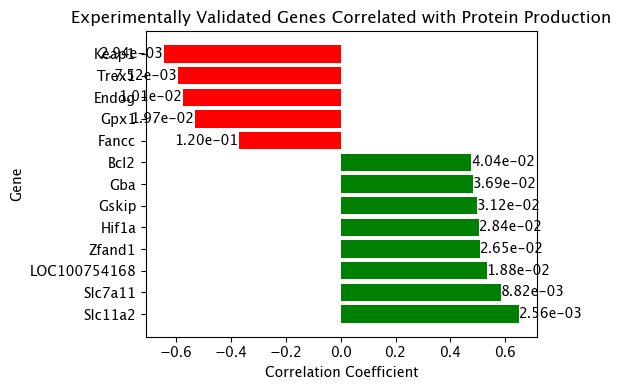

In [85]:
# Filter correlation_df for the custom genes only
selected_genes = correlation_df_protein[correlation_df_protein['Gene'].isin(ox_genes)].reset_index(drop=True)

plt.figure(figsize=(6, 4))
bars = plt.barh(
    selected_genes['Gene'], 
    selected_genes['Correlation'], 
    color=['green' if corr > 0 else 'red' for corr in selected_genes['Correlation']]
)

# Annotate bars with p-values
for bar, p_value in zip(bars, selected_genes['P-Value']):
    plt.text(
        bar.get_width(),  # Position at the end of the bar
        bar.get_y() + bar.get_height() / 2,  # Center vertically on the bar
        f'{p_value:.2e}',  # Format p-value in scientific notation
        va='center',  # Align vertically centered
        ha='left' if bar.get_width() > 0 else 'right'  # Adjust alignment for positive/negative bars
    )

plt.title('Experimentally Validated Genes Correlated with Protein Production')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Gene')
plt.tight_layout()
plt.show()

### 4.2 Correlation with AA comp Cisteine

In [86]:
# Filter out genes with constant values or missing data
filtered_data = highno_combined_data.dropna(axis=0).loc[:, highno_combined_data.nunique() > 1]

# Initialize a dictionary to store correlation results
correlation_results = {'Gene': [], 'Correlation': [], 'P-Value': []}

# Iterate over each gene
for gene in filtered_data.columns[:-1]:  # Exclude 'Total_protein_microg'
    gene_expression = filtered_data[gene]
    aa_comp_c = filtered_data['Comp_C']

    # Calculate Pearson correlation
    corr, p_value = pearsonr(gene_expression, aa_comp_c)

    # Append results
    correlation_results['Gene'].append(gene)
    correlation_results['Correlation'].append(corr)
    correlation_results['P-Value'].append(p_value)

# Convert results to a DataFrame
correlation_df_cysteine = pd.DataFrame(correlation_results).sort_values(by='Correlation', ascending=False)
correlation_df_cysteine.reset_index(inplace=True, drop=True)

# Display results
print("Top Genes Positively Correlated with Cisteine Composition:")
print(correlation_df.head(10))
print('')
print("Top Genes Negatively Correlated with Cisteine Composition:")
print(correlation_df.tail(10))

/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/ipykernel_13799/261762234.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_value = pearsonr(gene_expression, aa_comp_c)


Top Genes Positively Correlated with Cisteine Composition:
           Gene  Correlation   P-Value
0  LOC107978826     0.806997  0.000030
1          Ano6     0.768687  0.000120
2  LOC100772093     0.764894  0.000136
3          Il20     0.758828  0.000165
4        Hivep1     0.757982  0.000170
5  LOC100761556     0.757557  0.000172
6  LOC107980087     0.756270  0.000179
7          Fggy     0.753414  0.000196
8         Peak1     0.747937  0.000231
9         Prkcd     0.743952  0.000260

Top Genes Negatively Correlated with Cisteine Composition:
               Gene  Correlation   P-Value
18504        Smim20    -0.701954  0.000808
18505         Rps26    -0.702755  0.000792
18506         Crocc    -0.705790  0.000734
18507  LOC103164274    -0.706443  0.000722
18508  LOC107980326    -0.711871  0.000629
18509         Nr2f6    -0.715685  0.000570
18510  LOC103158789    -0.719290  0.000518
18511        Gtpbp6    -0.723480  0.000464
18512         Cxxc5    -0.725170  0.000443
18513  LOC100756957   

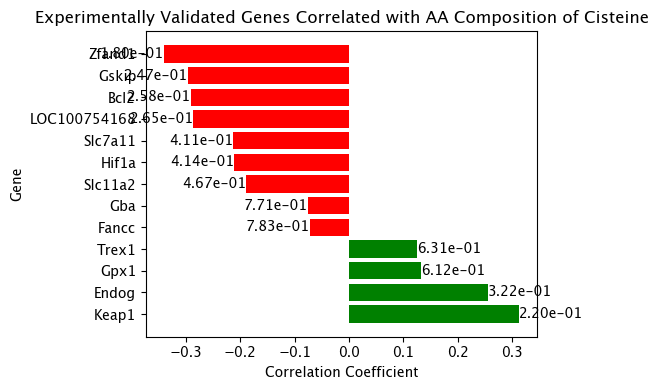

In [87]:
# Oxidative stress genes

ox_genes = ['Keap1', 'Trex1', 'Endog', 'Fancc', 'Gpx1', 'Gskip', 'LOC100754168', 'Zfand1', 'Hif1a',
            'Gba', 'Slc7a11','Bcl2', 'Slc11a2']

# Filter correlation_df for the custom genes only
selected_genes = correlation_df_cysteine[correlation_df_cysteine['Gene'].isin(ox_genes)].reset_index(drop=True)

plt.figure(figsize=(6, 4))
bars = plt.barh(
    selected_genes['Gene'], 
    selected_genes['Correlation'], 
    color=['green' if corr > 0 else 'red' for corr in selected_genes['Correlation']]
)

# Annotate bars with p-values
for bar, p_value in zip(bars, selected_genes['P-Value']):
    plt.text(
        bar.get_width(),  # Position at the end of the bar
        bar.get_y() + bar.get_height() / 2,  # Center vertically on the bar
        f'{p_value:.2e}',  # Format p-value in scientific notation
        va='center',  # Align vertically centered
        ha='left' if bar.get_width() > 0 else 'right'  # Adjust alignment for positive/negative bars
    )

plt.title('Experimentally Validated Genes Correlated with AA Composition of Cisteine')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Gene')
plt.tight_layout()
plt.show()

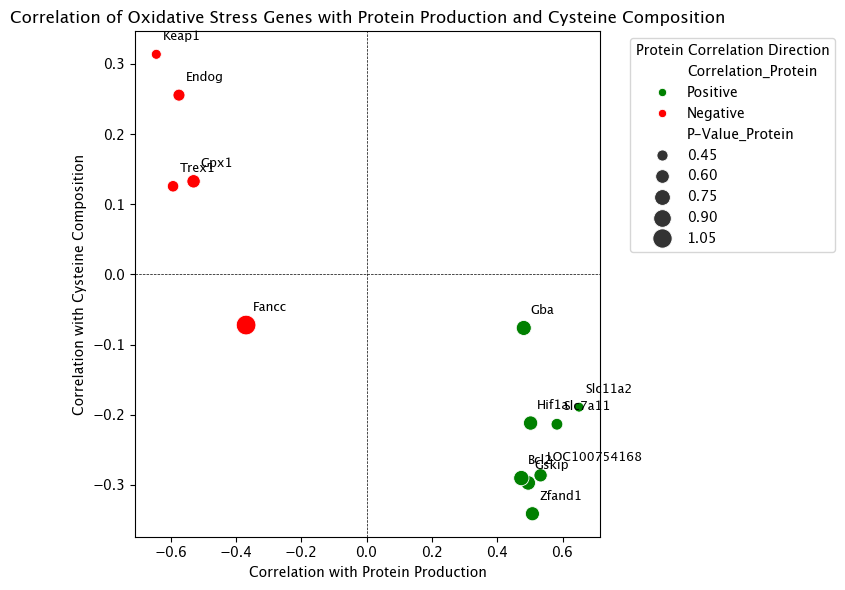

In [94]:
# Merge the two correlation DataFrames on the 'Gene' column
combined_corr_df = pd.merge(
    correlation_df_protein[['Gene', 'Correlation', 'P-Value']].rename(columns={'Correlation': 'Correlation_Protein', 'P-Value': 'P-Value_Protein'}),
    correlation_df_cysteine[['Gene', 'Correlation', 'P-Value']].rename(columns={'Correlation': 'Correlation_Cysteine', 'P-Value': 'P-Value_Cysteine'}),
    on='Gene'
)

# Filter for oxidative stress genes
combined_corr_df = combined_corr_df[combined_corr_df['Gene'].isin(ox_genes)]

# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=combined_corr_df,
    x='Correlation_Protein',
    y='Correlation_Cysteine',
    hue=combined_corr_df['Correlation_Protein'].apply(lambda x: 'Positive' if x > 0 else 'Negative'),  # Color by protein correlation direction
    size=combined_corr_df['P-Value_Protein'].apply(lambda x: 1 / -np.log10(x)),
    sizes=(50, 200),  # Adjust size range
    palette={'Positive': 'green', 'Negative': 'red'}  # Color palette
)

# Add gene names as annotations
for i, row in combined_corr_df.iterrows():
    plt.text(
        row['Correlation_Protein'] + 0.02,  # Offset for better visibility
        row['Correlation_Cysteine'] + 0.02,
        row['Gene'],
        fontsize=9,
        ha='left'
    )

# Add labels and title
plt.xlabel('Correlation with Protein Production')
plt.ylabel('Correlation with Cysteine Composition')
plt.title('Correlation of Oxidative Stress Genes with Protein Production and Cysteine Composition')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)  # Add horizontal line at y=0
plt.axvline(0, color='black', linestyle='--', linewidth=0.5)  # Add vertical line at x=0
plt.legend(title='Protein Correlation Direction', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig('results/Corr_oxi_stress_genes_cysteinevsprotyield.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()